In [1]:
#Reference: 
#   Cunxi Yu, Houping Xiao and Giovanni De Micheli. 
#   "Developing Synthesis Flows without Human Knowledge." ACM/IEEE Design Automation Conference (DAC'18)
#   Contact: Cunxi Yu.  Email: cunxi.yu@epfl.ch
#
#
#Demo: Input design/datasets: 64-bit GF-Mont with delay labels.
#        Number of classes: 7 (0-6)
#Demo 
#    Training Results:
#        1) Angel flows classifcation (class-0): 88%
#        2) Devil flows classifcation (class-0): 93%
#        3) overall accuracy of classifer 74.67%         
#    Testing Results: 
#        1) Angel flows classifcation (class-0): 87%
#        2) Devil flows classifcation (class-0): 93%
#        3) overall accuracy of classifer 73.64%

In [2]:
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Conv2D,Flatten,MaxPooling2D
from keras.utils import to_categorical
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use('Agg')
from sklearn.metrics import confusion_matrix
import itertools




Using TensorFlow backend.
/Users/cunxiyu/miniconda2/lib/python2.7/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [3]:
def read_csv_data(csv_filename, header=None, num_funcs=6, shuffle_data=True):
    """helper function to read data from csv file
    return X and Y
    X.shape = (num_samples, length_seq, num_funcs)
    Y.shape = (num_samples, num_classes)
    """
    # read data
    data = pd.read_csv(csv_filename, header=header)
    data = data.as_matrix()
    if (shuffle_data):
        data = shuffle(data)

    # extract X and Y
    X = data[:, :-1]#.reshape((-1, int((data.shape[1]-1)/num_funcs), num_funcs))
    X = data[:, :-1].reshape(X.shape[0], 1, 24, 6)
    Y = data[:, -1]

    # convert Y to one-hot vectors
    Y = to_categorical(Y, num_classes=Y.max()+1)

    return X, Y

In [4]:
from keras.callbacks import Callback
from IPython.display import clear_output
class PlotLearning(Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.i += 1

        #self.plot_history()

    def plot_history(self):
        #f, ax1 = plt.subplots()
        f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
        clear_output(wait=True)
        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val_loss")
        ax1.legend()
        ax2.plot(self.x, self.acc, label="accuracy")
        ax2.plot(self.x, self.val_acc, label="validation accuracy")
        ax2.legend()
        plt.show()

plot_learning = PlotLearning()

In [13]:
##training input data: test.csv
folder_path = 'datasets/64bitGF/delay/'
csv_filename = 'test.csv'
X, Y = read_csv_data(folder_path + csv_filename, header=None, num_funcs=6)
print("X.shape = ", X.shape)
print("Y.shape = ", Y.shape)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=2)

('X.shape = ', (20000, 1, 24, 6))
('Y.shape = ', (20000, 7))


In [14]:
input_shape = (1, 24, 6)
model = Sequential()

num_classes=7
model.add(Conv2D(32, kernel_size=(1, 2),
                 activation='elu',
                 input_shape=input_shape))
model.add(Conv2D(64, (1, 2), activation='elu', name = "conv2"))
model.add(MaxPooling2D(pool_size=(1, 1)))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(64, activation='selu'))
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))
model.summary()
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, Y_train,
          batch_size=64,
          epochs=100,
          verbose=2,
          validation_data=(X_test, Y_test), callbacks=[plot_learning])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 1, 23, 32)         416       
_________________________________________________________________
conv2 (Conv2D)               (None, 1, 22, 64)         4160      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 1, 22, 64)         0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 1, 22, 64)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1408)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                90176     
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
__________

Epoch 81/100
 - 2s - loss: 0.4738 - acc: 0.8047 - val_loss: 0.6332 - val_acc: 0.7448
Epoch 82/100
 - 2s - loss: 0.4828 - acc: 0.7964 - val_loss: 0.6131 - val_acc: 0.7462
Epoch 83/100
 - 2s - loss: 0.4715 - acc: 0.8056 - val_loss: 0.6338 - val_acc: 0.7372
Epoch 84/100
 - 2s - loss: 0.4763 - acc: 0.7981 - val_loss: 0.6040 - val_acc: 0.7443
Epoch 85/100
 - 2s - loss: 0.4722 - acc: 0.7989 - val_loss: 0.6365 - val_acc: 0.7422
Epoch 86/100
 - 2s - loss: 0.4703 - acc: 0.8026 - val_loss: 0.6234 - val_acc: 0.7388
Epoch 87/100
 - 2s - loss: 0.4622 - acc: 0.8060 - val_loss: 0.6278 - val_acc: 0.7463
Epoch 88/100
 - 2s - loss: 0.4740 - acc: 0.8016 - val_loss: 0.6239 - val_acc: 0.7442
Epoch 89/100
 - 2s - loss: 0.4630 - acc: 0.8097 - val_loss: 0.6402 - val_acc: 0.7417
Epoch 90/100
 - 2s - loss: 0.4636 - acc: 0.8061 - val_loss: 0.6193 - val_acc: 0.7478
Epoch 91/100
 - 2s - loss: 0.4517 - acc: 0.8113 - val_loss: 0.6390 - val_acc: 0.7435
Epoch 92/100
 - 2s - loss: 0.4583 - acc: 0.8101 - val_loss: 0.612

In [15]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          print_raw_cm=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        if (print_raw_cm):
            print("Normalized confusion matrix")
    else:
        if (print_raw_cm):
            print('Confusion matrix, without normalization')

    if (print_raw_cm):
        print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Greys)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    #plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
def evaluate(model, X_test, Y_test, classes,NAME):
    """evaluate dataset and plot confusion matrix"""
    # predict from X_test
    Y_pred = model.predict(X_test)
    Y_pred_label = np.argmax(Y_pred, axis=-1)
    Y_test_label = np.argmax(Y_test, axis=-1)


    print("Prediction accuracy = %f" %(float(sum(Y_pred_label == Y_test_label))/Y_test_label.shape[0]))
    cnf_matrix = confusion_matrix(Y_test_label, Y_pred_label)


    np.set_printoptions(precision=2)
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=classes, normalize=True,
                          title='Normalized confusion matrix\n Angel-class:class-0\n Devil-class:class-6')
    
    plt.show()



Prediction accuracy = 0.746667


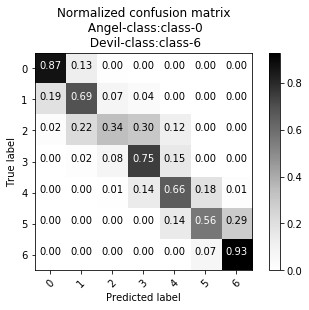

In [16]:
##evaluate training results
evaluate(model, X_test, Y_test, classes=range(0,Y.shape[1]),NAME = "origin_delay_")

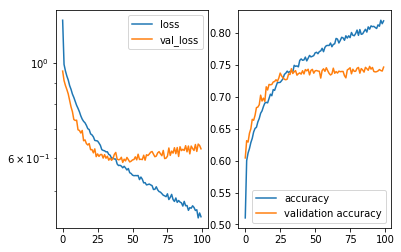

In [17]:
plot_learning.plot_history()

((20000, 1, 24, 6), (20000, 7))
Prediction accuracy = 0.736400


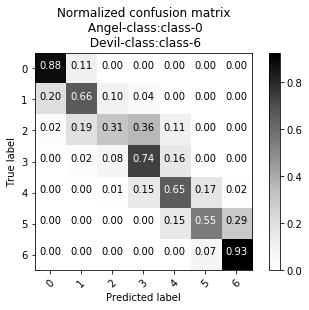

In [21]:
##testing (inference)
#testing input datasets: 20000 untested flows, test2.csv

folder_path = 'datasets/64bitGF/delay/'
csv_filename = 'test2.csv'
X, Y = read_csv_data(folder_path + csv_filename, header=None, num_funcs=6)
print(X.shape, Y.shape)
evaluate(model, X, Y, classes=range(0,Y.shape[1]),NAME = "origin_delay_")